Modified from https://lectures.quantecon.org/jl/lake_model.html
Generated from: _build_jl/jl/lake_model.rst  
@author : Victoria Gregory, John Stachurski

## Structure to hold the parameters

In [1]:
#A list of parameters to store
struct LakeModel{TF <: AbstractFloat}
    λ::TF
    α::TF
    b::TF
    d::TF
    g::TF
    A::Matrix{TF}
    A_hat::Matrix{TF}
end

#Constructor generates default values and does calculations
function LakeModel(;λ::AbstractFloat=0.283,
                    α::AbstractFloat=0.013,
                    b::AbstractFloat=0.0124,
                    d::AbstractFloat=0.00822)

    g = b - d
    A = [(1-λ) * (1-d) + b  (1-d) * α + b;
         (1-d) * λ          (1-d) * (1-α)]
    A_hat = A ./ (1 + g)

    return LakeModel(λ, α, b, d, g, A, A_hat)
end

LakeModel

## Examples using LakeModel
Can use with all defaults or modify the parameters

In [2]:
#Defaults
lm = LakeModel()
@show lm.α
@show lm.A

#MOdifying Defaults
lm = LakeModel(α = 2.0)
@show lm.α
@show lm.A

lm.α = 0.013
lm.A = [0.723506 0.0252931; 0.280674 0.978887]
lm.α = 2.0
lm.A = [0.723506 1.99596; 0.280674 -0.99178]


2×2 Array{Float64,2}:
 0.723506   1.99596
 0.280674  -0.99178

## Calculation of the steady state, simulations, etc.

In [3]:
#Calculates the steady state by iterating forward
#Could have use the eigenvalues of the A_hat as well
function rate_steady_state(lm::LakeModel, tol::AbstractFloat=1e-6)
    x = 0.5 * ones(2)
    error = tol + 1
    while (error > tol)
        new_x = lm.A_hat * x
        error = maximum(abs, new_x - x)
        x = new_x
    end
    return x
end

#Simulates the stock evolution with lm.A
function simulate_stock_path{TF<:AbstractFloat}(lm::LakeModel,
                                                X0::AbstractVector{TF},
                                                T::Integer)
    X_path = Array{TF}(2, T)
    X = copy(X0)
    for t in 1:T
        X_path[:, t] = X
        X = lm.A * X
    end
    return X_path
end

#Simulates the rates
function simulate_rate_path{TF<:AbstractFloat}(lm::LakeModel,
                                               x0::Vector{TF},
                                               T::Integer)
    x_path = Array{TF}(2, T)
    x = copy(x0)
    for t in 1:T
        x_path[:, t] = x
        x = lm.A_hat * x
    end
    return x_path
end

simulate_rate_path (generic function with 1 method)

## Aggregate Dynamics
Simulations of the LakeModel Stocks from the default parameters

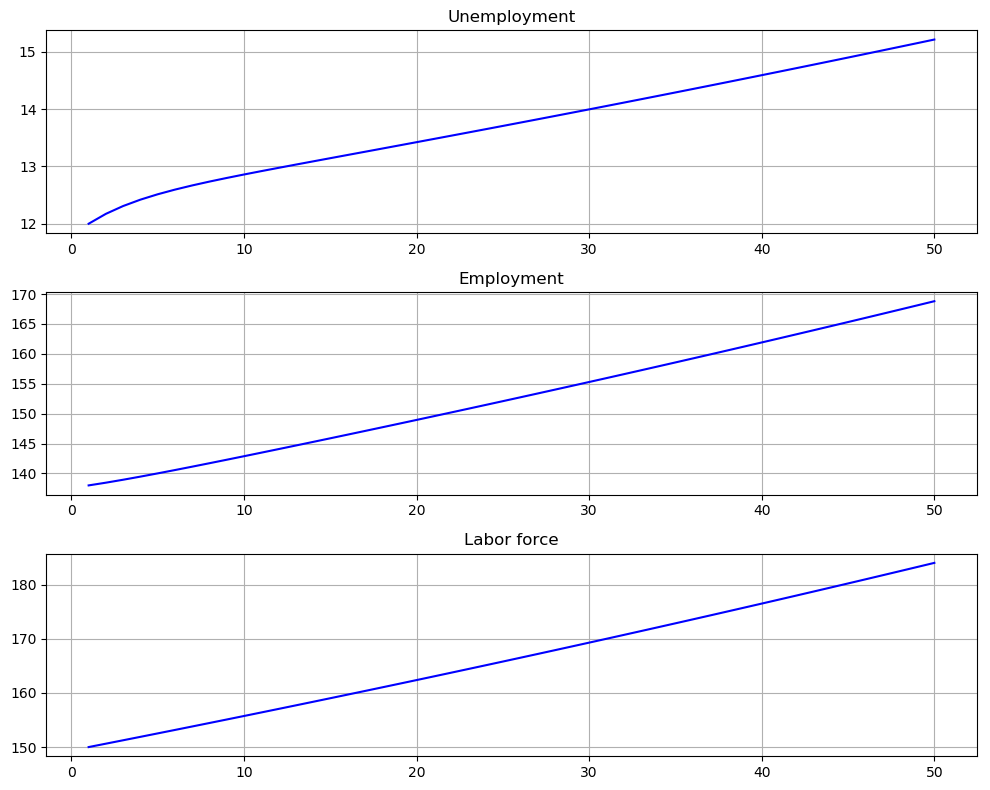

In [4]:
using PyPlot

lm = LakeModel()
N_0 = 150      # Population
e_0 = 0.92     # Initial employment rate
u_0 = 1 - e_0  # Initial unemployment rate
T = 50         # Simulation length

U_0 = u_0 * N_0
E_0 = e_0 * N_0
X_0 = [U_0; E_0]

X_path = simulate_stock_path(lm, X_0, T)


x1 = X_path[1, :]
x2 = X_path[2, :]
x3 = squeeze(sum(X_path, 1), 1) #Adding up the unemployed and the employed

#Don't worry about the details of this general way to create graphs
titles = ["Unemployment" "Employment" "Labor force"]
fig, axes = subplots(3, 1, figsize=(10, 8))

for (ax, x, title) in zip(axes, [x1, x2, x3], titles)
    ax[:plot](1:T, x, c="blue")
    ax[:set](title=title)
    ax[:grid]("on")
end

fig[:tight_layout]()

## Simulating the Rates
Convergence of the unemployment and employment rate to steady state levels 

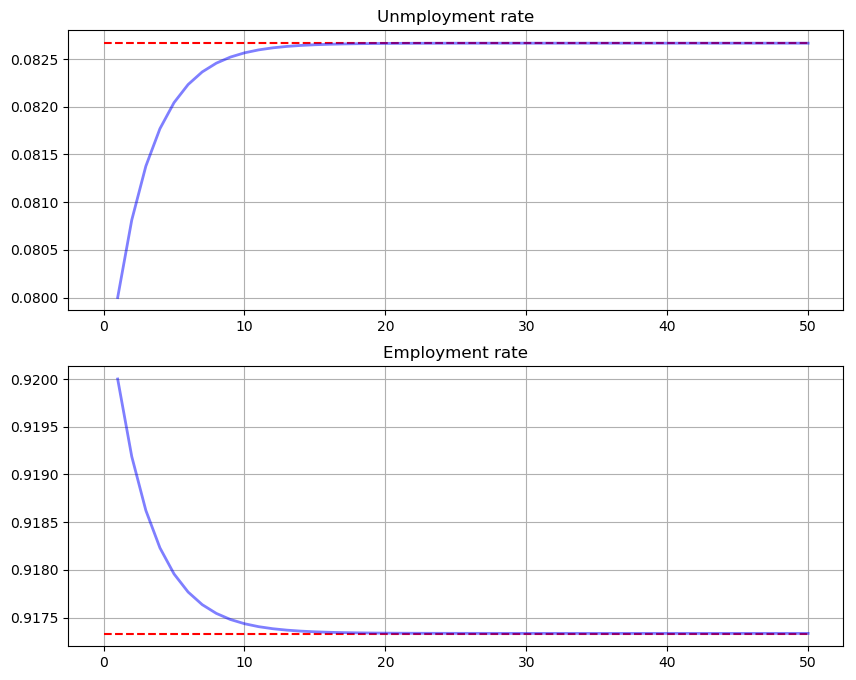

In [5]:
lm = LakeModel()
e_0 = 0.92     # Initial employment rate
u_0 = 1 - e_0  # Initial unemployment rate
T = 50         # Simulation length

xbar = rate_steady_state(lm)
x_0 = [u_0; e_0]
x_path = simulate_rate_path(lm, x_0, T)


#Don't worry about the details of this general way to create graphs
titles = ["Unmployment rate" "Employment rate"]
fig, axes = subplots(2, 1, figsize=(10, 8))
for (i, ax) in enumerate(axes)
    ax[:plot](1:T, x_path[i, :], c="blue", lw=2, alpha=0.5)
    ax[:hlines](xbar[i], 0, T, "r", "--")
    ax[:set](title=titles[i])
    ax[:grid]("on")
end

## Dynamics of an Individual Worker
Simulating the Markov Chain for a Worker
Demonstrating the ergodic properties

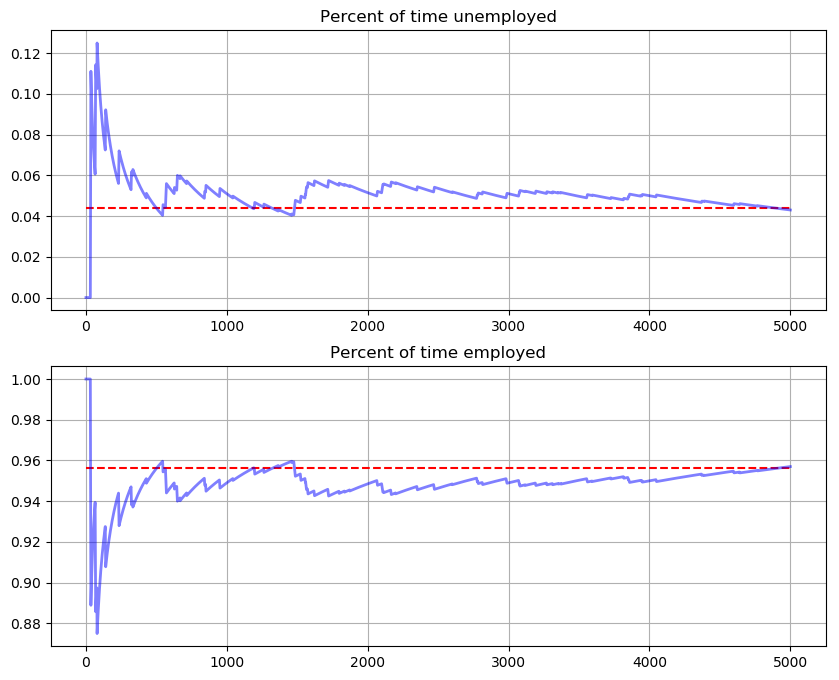

In [7]:
using QuantEcon
srand(42)
lm = LakeModel(d=0.0, b=0.0)

#Creates the markov chain with the smae parameters as the default LakeModel
α, λ = lm.α, lm.λ
P = [(1 - λ)     λ; 
     α       (1 - α)]
mc = MarkovChain(P, [0; 1])     # 0=unemployed, 1=employed
xbar = rate_steady_state(lm) #Can check that the steady state of the aggregates coincides with a worker


#Simulate
T = 5000
s_path = simulate(mc, T; init=2)
s_bar_e = cumsum(s_path) ./ (1:T) #Adding up the number of s_path.  Note that since 0 = unemployed and 1 = employed, this is number of periods employed
s_bar_u = 1 - s_bar_e
s_bars = [s_bar_u s_bar_e]

#Don't worry about the details of this general way to create graphs
titles = ["Percent of time unemployed" "Percent of time employed"]
fig, axes = subplots(2, 1, figsize=(10, 8))
for (i, ax) in enumerate(axes)
    ax[:plot](1:T, s_bars[:, i], c="blue", lw=2, alpha=0.5)
    ax[:hlines](xbar[i], 0, T, "r", "--")
    ax[:set](title=titles[i])
    ax[:grid]("on")
end

## Endogenous Job Finding Rate
Copying code directly from https://lectures.quantecon.org/jl/mccall_model.html
No need to modify

In [8]:
#Directly copying all.  No modifications necessary
using Distributions
function u(c::Real, σ::Real)
    if c > 0
        return (c^(1 - σ) - 1) / (1 - σ)
    else
        return -10e6
    end
end

# default wage vector with probabilities
n = 60                                   # n possible outcomes for wage
default_w_vec = linspace(10, 20, n)      # wages between 10 and 20
a, b = 600, 400                          # shape parameters
dist = BetaBinomial(n-1, a, b)
default_p_vec = pdf.(dist, support(dist))

mutable struct McCallModel{TF <: AbstractFloat,
                           TAV <: AbstractVector{TF},
                           TAV2 <: AbstractVector{TF}}
    α::TF         # Job separation rate
    β::TF         # Discount rate
    γ::TF         # Job offer rate
    c::TF         # Unemployment compensation
    σ::TF         # Utility parameter
    w_vec::TAV    # Possible wage values
    p_vec::TAV2   # Probabilities over w_vec

    McCallModel(α::TF=0.2,
                β::TF=0.98,
                γ::TF=0.7,
                c::TF=6.0,
                σ::TF=2.0,
                w_vec::TAV=default_w_vec,
                p_vec::TAV2=default_p_vec) where {TF, TAV, TAV2} =
        new{TF, TAV, TAV2}(α, β, γ, c, σ, w_vec, p_vec)
end

function update_bellman!(mcm::McCallModel,
                         V::AbstractVector,
                         V_new::AbstractVector,
                         U::Real)
    # Simplify notation
    α, β, σ, c, γ = mcm.α, mcm.β, mcm.σ, mcm.c, mcm.γ

    for (w_idx, w) in enumerate(mcm.w_vec)
        # w_idx indexes the vector of possible wages
        V_new[w_idx] = u(w, σ) + β * ((1 - α) * V[w_idx] + α * U)
    end

    U_new = u(c, σ) + β * (1 - γ) * U +
                    β * γ * dot(max.(U, V), mcm.p_vec)

    return U_new
end
function solve_mccall_model(mcm::McCallModel;
                            tol::AbstractFloat=1e-5,
                            max_iter::Integer=2000)

    V = ones(length(mcm.w_vec))    # Initial guess of V
    V_new = similar(V)             # To store updates to V
    U = 1.0                        # Initial guess of U
    i = 0
    error = tol + 1

    while error > tol && i < max_iter
        U_new = update_bellman!(mcm, V, V_new, U)
        error_1 = maximum(abs, V_new - V)
        error_2 = abs(U_new - U)
        error = max(error_1, error_2)
        V[:] = V_new
        U = U_new
        i += 1
    end

    return V, U
end
function compute_reservation_wage(mcm::McCallModel; return_values::Bool=false)

    V, U = solve_mccall_model(mcm)
    w_idx = searchsortedfirst(V - U, 0)

    if w_idx == length(V)
        w_bar = Inf
    else
        w_bar = mcm.w_vec[w_idx]
    end

    if return_values == false
        return w_bar
    else
        return w_bar, V, U
    end

end

compute_reservation_wage (generic function with 1 method)

# Global Variables for Fiscal Policy Examples
Sets wage distribution,  parameters, etc.

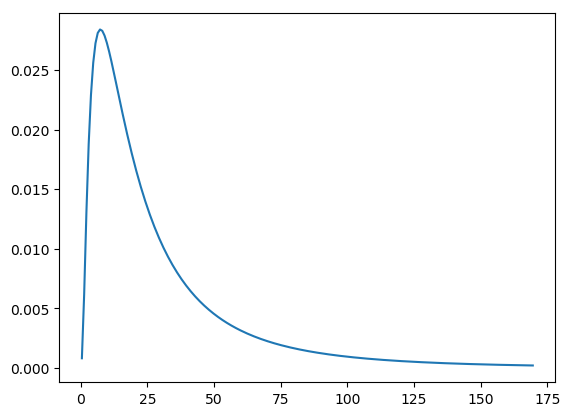

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x000000000332B5C0>

In [9]:
# Some global variables that will stay constant
α = 0.013
α_q = (1 - (1 - α)^3) #A calibration on the rate of leaving employment
b_param = 0.0124 #Birth rate in the US population
d_param = 0.00822 #Death rate in the US population
β = 0.98
γ = 1.0
σ = 2.0

# The default wage distribution: a discretized log normal
# Don't worry about the details
log_wage_mean, wage_grid_size, max_wage = 20, 200, 170
w_vec = linspace(1e-3, max_wage, wage_grid_size + 1)
logw_dist = Normal(log(log_wage_mean), 1)
cdf_logw = cdf.(logw_dist, log.(w_vec))
pdf_logw = cdf_logw[2:end] - cdf_logw[1:end-1]
p_vec = pdf_logw ./ sum(pdf_logw)
w_vec = (w_vec[1:end-1] + w_vec[2:end]) / 2

#Visualize the PDF of the wages
plot(w_vec, p_vec)

## Calculate λ from McCall Decision
Fix a c and τ: calculates w_bar, etc. from the McCall code


In [10]:
#=
Compute the reservation wage, job finding rate and value functions of the
workers given c and τ.
=#
function compute_optimal_quantities(c::AbstractFloat, τ::AbstractFloat)
    mcm = McCallModel(α_q, #Using default values established before except for c and τ
                      β,
                      γ,
                      c-τ,                # post-tax compensation.  Remove τ for everyone
                      σ,
                      collect(w_vec-τ),   # post-tax wages.  Remove τ for everyone
                      p_vec)


    #Use the McCall code to return the reservation wage, value functions, etc.
    w_bar, V, U = compute_reservation_wage(mcm, return_values=true)
    
    #See equation (1)  The probability of leaving unemployment given decision rule and exogenous gamma.
    λ = γ * sum(p_vec[w_vec - τ .> w_bar])

    return w_bar, λ, V, U
end

compute_optimal_quantities (generic function with 1 method)

## Compute Steady State (given τ and c)
This uses the LakeModel code to calculate the steady state unemployment, employment, etc. rates

In [11]:
#=
Compute the steady state unemployment rate given c and tau using optimal
quantities from the McCall model and computing corresponding steady state
quantities
=#

function compute_steady_state_quantities(c::AbstractFloat, τ::AbstractFloat)
    
    #Use the function above to calculate using McCall search
    w_bar, λ_param, V, U = compute_optimal_quantities(c, τ)

    # Compute steady state employment and unemployment rates
    # Uses the LakeModel code
    lm = LakeModel(λ=λ_param, α=α_q, b=b_param, d=d_param)
    x = rate_steady_state(lm)
    
    #The steady state unemployment and employment are important for welfare and budgets
    u_rate, e_rate = x

    # Compute steady state welfare
    #First, calculate the expectation of V given they are employed. Expectation(V | employed)
    #Requires calculating the conditional probability distribution above the threshold
    w = sum(V .* p_vec .* (w_vec - τ .> w_bar)) / sum(p_vec .* (w_vec - τ .> w_bar))
    
    #See W:= e Expectation(V | employed) + u U    
    welfare = e_rate .* w + u_rate .* U

    return u_rate, e_rate, welfare
end


#=
Find tax level that will induce a balanced budget.
=#
function find_balanced_budget_tax(c::Real)
    
    #Creates a function of the tax to determine the steady state budget
    #Note: this fixes the "c" in the calculation of the function
    function steady_state_budget(t::Real)
      u_rate, e_rate, w = compute_steady_state_quantities(c, t)
    
        #The budget  is the tax on all and the unemployment benefits
      return t - u_rate * c
    end

    # "brent" finds a solution to a nonlinear univariate equation.
    # Here, given the fixed "c" it finds the τ which balances the budget exactly
    τ = brent(steady_state_budget, 0.0, 0.9 * c) #The [0.0, 0.9*c] are just the bounds to look for a solution.

    return τ #Returns the budget balancing tax rate for the given c
end


find_balanced_budget_tax (generic function with 1 method)

## An Example

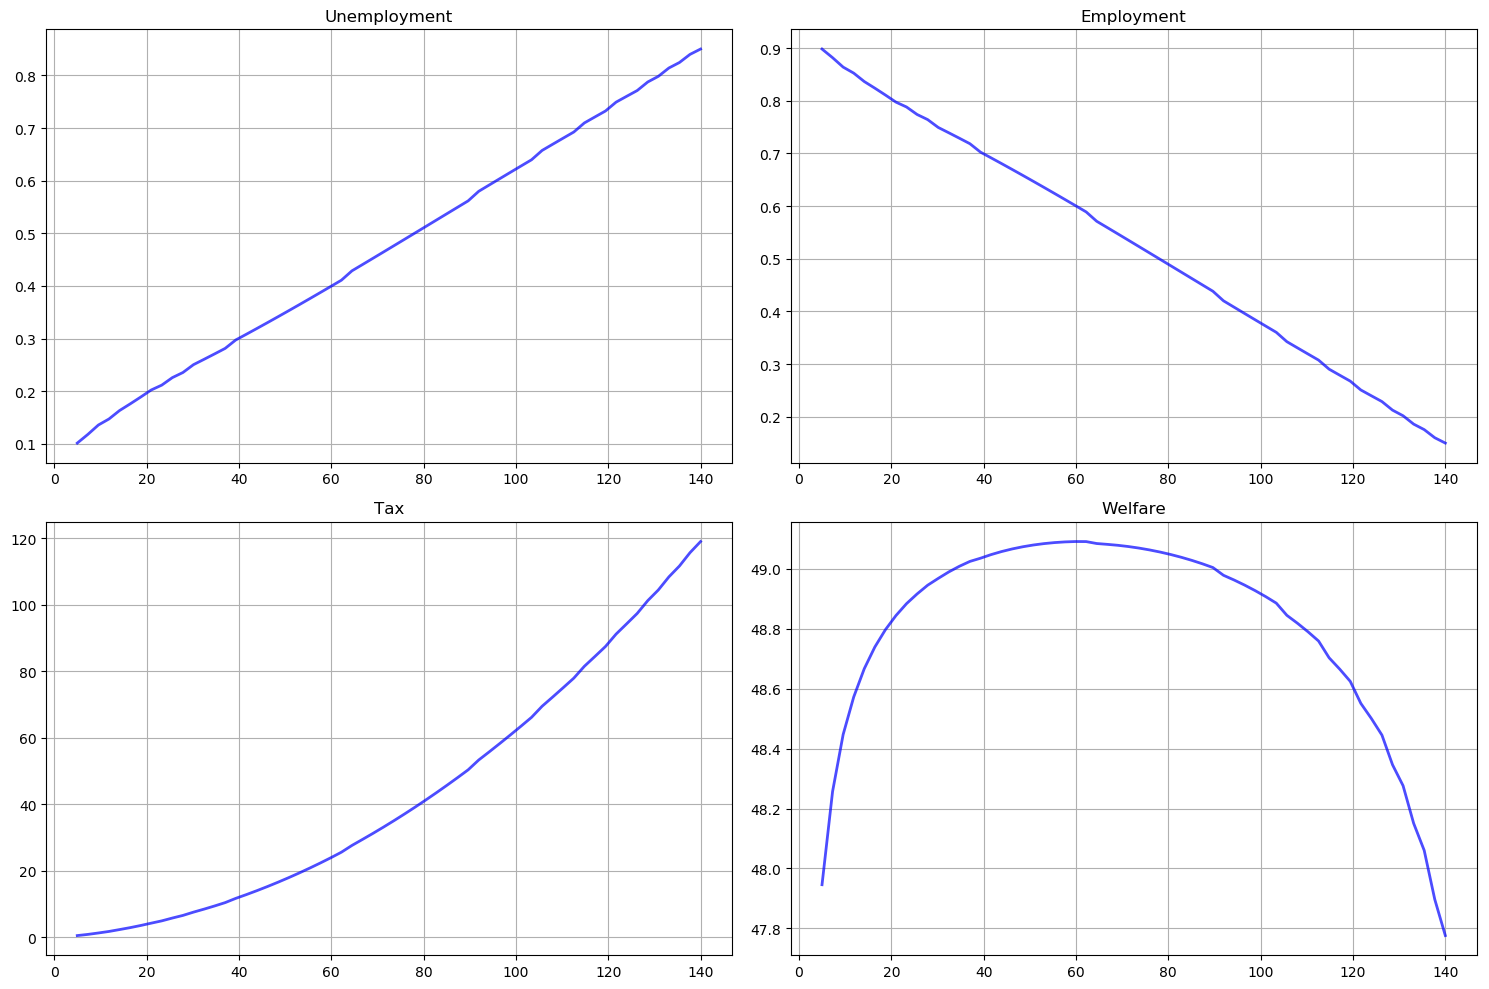

In [12]:
# Levels of unemployment insurance we wish to study
Nc = 60
c_vec = linspace(5.0, 140.0, Nc) #Nc points between c = 5.0 and c = 140.0


#Some vectors to store the results
tax_vec = Vector{Float64}(Nc)
unempl_vec = Vector{Float64}(Nc)
empl_vec = Vector{Float64}(Nc)
welfare_vec = Vector{Float64}(Nc)

#Will calculate this for every c in that range
for i = 1:Nc    
    #For the given c = c_vec[i]... find the balanced budget taxes
    t = find_balanced_budget_tax(c_vec[i])
    
    #Then given the balanced budget taxes, calculate the welfare and rates.
    u_rate, e_rate, welfare = compute_steady_state_quantities(c_vec[i], t)
    tax_vec[i] = t
    unempl_vec[i] = u_rate
    empl_vec[i] = e_rate
    welfare_vec[i] = welfare
end


#Don't worry about the details of this general way to create graphs
fig, axes = subplots(2, 2, figsize=(15, 10))
plots = [unempl_vec, tax_vec, empl_vec, welfare_vec]
titles = ["Unemployment", "Tax", "Employment", "Welfare"]
for (ax, plot, title) in zip(axes, plots, titles)
     ax[:plot](c_vec, plot, "b-", lw=2, alpha=0.7)
     ax[:set](title=title)
     ax[:grid]("on")
end
fig[:tight_layout]()